In [1]:
import trading_vix_and_spy
import numpy as np
import pandas as pd
import trading_vix_and_spy_utils

In [2]:
free_parameters = {}
free_parameters['inner_denoise_std'] = 2
free_parameters['outer_denoise_std'] = 2
free_parameters['buy_1_threshold'] = 1
free_parameters['buy_2_threshold'] = 2
free_parameters['sell_1_threshold'] = 1
free_parameters['sell_2_threshold'] = 2
free_parameters['inner_window_length_interval'] = 10 #in unit of days
free_parameters['outer_window_length_interval'] = 25
free_parameters['buy_1_wait'] = 4 #in unit of days
free_parameters['buy_2_wait'] = 4
free_parameters['sell_1_wait'] = 4
free_parameters['sell_2_wait'] = 4
free_parameters['min_profit'] = 0.5 #in unit of percentage

In [3]:
#convert the window length from unit of days into interval count
days_into_interval = 1

In [4]:
local_env = trading_vix_and_spy.trading_vix_and_spy()
local_env.seed(4)

In [5]:
spy_action_history = []
inner_lower_bound_history = []
inner_upper_bound_history = []
outer_lower_bound_history = []
outer_upper_bound_history = []
total_spy_value = []
spy_price_history = None
spy_buy_sell = []

In [6]:
full_observation = local_env.reset()

In [7]:
full_observation = local_env.reset()
spy_observation = full_observation[5]

last_buy_1_time = -99999
last_buy_2_time = -99999
last_sell_1_time = -99999
last_sell_2_time = -99999

time_index = 0

while True:
    
    inner_lower_bound, inner_upper_bound = trading_vix_and_spy_utils.generate_spy_bounds(
        spy_observation,
        int(free_parameters['inner_window_length_interval']*days_into_interval),
        free_parameters['inner_denoise_std'],
        free_parameters['buy_1_threshold'],
        free_parameters['sell_1_threshold']
    )

    outer_lower_bound, outer_upper_bound = trading_vix_and_spy_utils.generate_spy_bounds(
        spy_observation,
        int(free_parameters['outer_window_length_interval']*days_into_interval),
        free_parameters['outer_denoise_std'],
        free_parameters['buy_2_threshold'],
        free_parameters['sell_2_threshold']
    )
    
    current_spy_price = spy_observation[-1]
    
    action = 0.5 #do nothing action is 0.5
    action_type = None
    #see if we can buy
    if current_spy_price < inner_lower_bound and current_spy_price > outer_lower_bound:
        time_since_last_buy = (time_index-last_buy_1_time) #time_since_last_buy is in unit of interval
        if time_since_last_buy > free_parameters['buy_1_wait']*days_into_interval:
            action = 1
            action_type = 'buy_1'
    if current_spy_price < inner_lower_bound and current_spy_price < outer_lower_bound:
        time_since_last_buy = (time_index-last_buy_2_time)
        if time_since_last_buy > free_parameters['buy_2_wait']*days_into_interval:
            action = 1
            action_type = 'buy_2'
    
    #see if we can sell
    if current_spy_price > inner_upper_bound and current_spy_price < outer_upper_bound:
        time_since_last_sell = (time_index-last_sell_1_time)
        if time_since_last_sell > free_parameters['sell_1_wait']*days_into_interval:
            action = 0
            action_type = 'sell_1'
            
    if current_spy_price > inner_upper_bound and current_spy_price > outer_upper_bound:
        time_since_last_sell = (time_index-last_sell_2_time)
        if time_since_last_sell > free_parameters['sell_2_wait']*days_into_interval:
            action = 0
            action_type = 'sell_2'
                  
    inner_lower_bound_history.append(inner_lower_bound)
    inner_upper_bound_history.append(inner_upper_bound)
    outer_lower_bound_history.append(outer_lower_bound)
    outer_upper_bound_history.append(outer_upper_bound)
    
    action_df = pd.DataFrame()
    action_df['0'] = [action] #don't buy or sell spy
    action_df['1'] = [0] #don't buy or sell any vix
    action_df['2'] = [0] #all the money is in spy
    
    action_array = action_df.iloc[0].tolist()
    action_array = np.reshape(action_array,(-1,))
    
    full_observation, reward, done, info = local_env.step(action_array)
    
    if info['bought_spy']:
        if action_type == 'buy_1':
            last_buy_1_time = time_index
        if action_type == 'buy_2':
            last_buy_2_time = time_index
    if info['sold_spy']:
        if action_type == 'sell_1':
            last_sell_1_time = time_index
        if action_type == 'sell_2':
            last_sell_2_time = time_index
    
    if info['bought_spy']:
        spy_buy_sell.append(1)
    elif info['sold_spy']:
        spy_buy_sell.append(-1)
    else:
        spy_buy_sell.append(0)
    
    total_spy_value.append(info['total_spy_value'])
    
    time_index += 1
    
    if done:
        spy_price_history = info['spy_price_trajectory']
        break

    spy_observation = full_observation[5]
    

In [8]:
print(len(spy_price_history))
print(len(inner_lower_bound_history))
print(len(total_spy_value))
print(len(spy_buy_sell))

101
101
101
101


In [9]:
import matplotlib.pyplot as plt

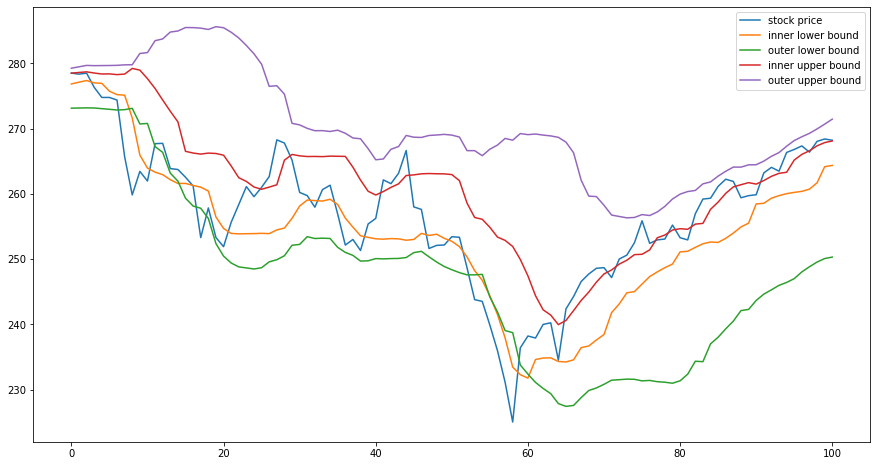

In [10]:
plt.rcParams["figure.figsize"] = (15,8)

plt.plot(spy_price_history,label = 'stock price')
plt.plot(inner_lower_bound_history,label = 'inner lower bound')
plt.plot(outer_lower_bound_history,label = 'outer lower bound')
plt.plot(inner_upper_bound_history,label = 'inner upper bound')
plt.plot(outer_upper_bound_history,label = 'outer upper bound')

plt.legend()
plt.show()

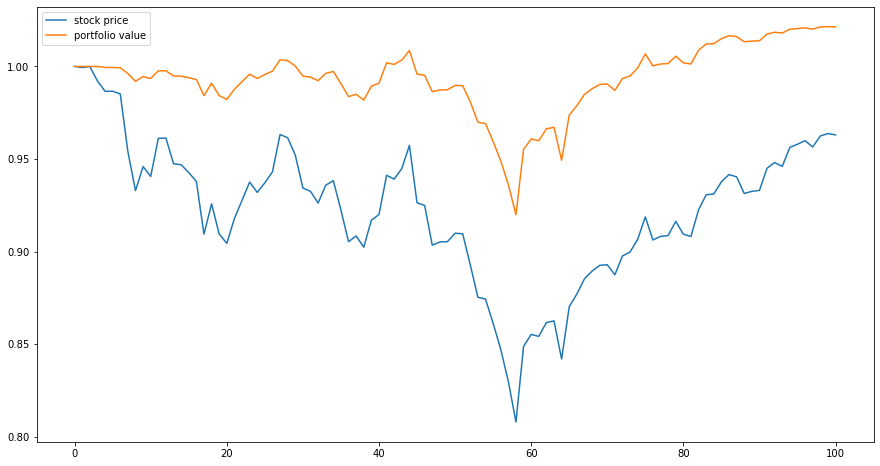

In [11]:
plt.plot(np.asarray(spy_price_history)/spy_price_history[0],label = 'stock price')
plt.plot(np.asarray(total_spy_value)/total_spy_value[0],label = 'portfolio value')
plt.legend()
plt.show()

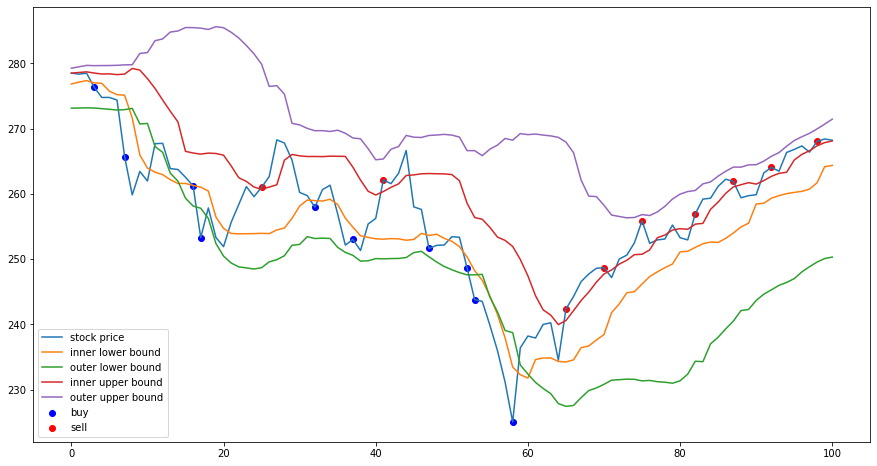

In [12]:


already_plotted_sell_legend = False
already_plotted_buy_legend = False

plt.plot(spy_price_history,label = 'stock price')
plt.plot(inner_lower_bound_history,label = 'inner lower bound')
plt.plot(outer_lower_bound_history,label = 'outer lower bound')
plt.plot(inner_upper_bound_history,label = 'inner upper bound')
plt.plot(outer_upper_bound_history,label = 'outer upper bound')

for time_index in range(0,len(spy_price_history)):

    if spy_buy_sell[time_index]==1:
        #print('the buy price is',price_history[time_index])
        if already_plotted_sell_legend == False:
            plt.scatter(time_index,spy_price_history[time_index],color = 'b',label = 'buy')
            already_plotted_sell_legend = True
        else:
            plt.scatter(time_index,spy_price_history[time_index],color = 'b')

    elif spy_buy_sell[time_index]==-1:
        #print('the sell price is',price_history[time_index])
        #print(' ')
        if already_plotted_buy_legend == False:
            plt.scatter(time_index,spy_price_history[time_index],color = 'r',label = 'sell')
            already_plotted_buy_legend = True
        else:
            plt.scatter(time_index,spy_price_history[time_index],color = 'r')
            
plt.legend()
plt.show()



In [13]:
reward

1215.8635200000017

In [14]:
info['total_spy_value']

51069.985400000005